# Tutorial 5 --- Extension Points for External Data

## Overview

Real-world quant research pipelines rarely rely on a single data source.
You may pull prices from Yahoo Finance today, switch to a Bloomberg
terminal tomorrow, and supplement with alternative data (news, sentiment,
satellite imagery) next quarter.  **qlab** is designed for this:

* A single abstract interface --- `MarketDataProvider` --- that every data
  source implements.
* A transparent `ParquetCache` decorator that makes any provider
  reproducible and fast.
* Clear data-format contracts so that every downstream function (features,
  alphas, backtest) works without modification when you swap providers.

This tutorial covers:

1. The `MarketDataProvider` interface
2. Live demonstration with `YFinanceProvider`
3. Implementing a custom provider from scratch
4. `ParquetCache` --- caching any provider to disk
5. Designing a `NewsProvider` interface for alternative data
6. Data format contracts
7. Reproducibility checklist and recommended project layout
8. Summary

## 1. The `MarketDataProvider` Interface

Every data source in qlab is a subclass of `MarketDataProvider`.  The
contract is minimal --- implement **one** method:

```
fetch(tickers, start, end) -> DataFrame
```

The returned DataFrame must have:
* A two-level `MultiIndex(date, ticker)`
* Columns: `open, high, low, close, volume, adj_close`

Let's inspect the actual source code.

In [1]:
import inspect
from qlab.data.base import MarketDataProvider

print(inspect.getsource(MarketDataProvider))

class MarketDataProvider(abc.ABC):
    """Base class for all market data providers.

    Subclasses must implement :meth:`fetch`, which returns a stacked
    DataFrame with MultiIndex ``(date, ticker)`` and columns
    ``open, high, low, close, volume, adj_close``.
    """

    @abc.abstractmethod
    def fetch(
        self,
        tickers: Sequence[str],
        start: str | pd.Timestamp,
        end: str | pd.Timestamp,
    ) -> pd.DataFrame:
        """Fetch OHLCV + adjusted close for the given tickers and date range.

        Parameters
        ----------
        tickers : sequence of str
            Equity symbols (e.g. ``['AAPL', 'MSFT']``).
        start, end : str or Timestamp
            Inclusive date boundaries.

        Returns
        -------
        DataFrame
            MultiIndex ``(date, ticker)`` with columns
            ``open, high, low, close, volume, adj_close``.
        """



Key design decisions:

| Decision | Rationale |
|----------|-----------|
| ABC with one abstract method | Minimal surface --- easy to implement |
| Stacked MultiIndex output | Uniform shape regardless of ticker count |
| `adj_close` included | Splits/dividends handled at the provider level |
| `start` / `end` as strings or Timestamps | Flexible input, provider normalises internally |

## 2. Live Demonstration with `YFinanceProvider`

`YFinanceProvider` wraps the popular `yfinance` package.  Let's fetch
real market data for a small universe and validate it.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (12, 5), "figure.dpi": 100,
                     "axes.grid": True, "grid.alpha": 0.3})

from qlab.data import YFinanceProvider, ParquetCache
from qlab.utils.validation import validate_prices
from qlab.features import simple_returns, rank
from qlab.utils.alignment import unstack_to_wide

# --- Fetch real data ---
TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
START, END = "2020-01-01", "2024-12-31"

provider = YFinanceProvider()
prices = provider.fetch(TICKERS, START, END)

# Validate using qlab's built-in checks
validate_prices(prices)
print("validate_prices passed!")

print(f"\nShape : {prices.shape}")
print(f"Columns: {list(prices.columns)}")
print(f"Index  : {prices.index.names}")
print(f"Tickers: {sorted(prices.index.get_level_values('ticker').unique())}")
print(f"Dates  : {prices.index.get_level_values('date').min().date()} to "
      f"{prices.index.get_level_values('date').max().date()}")
print(f"\nHead:")
prices.head(10)

validate_prices passed!

Shape : (6285, 6)
Columns: ['open', 'high', 'low', 'close', 'volume', 'adj_close']
Index  : ['date', 'ticker']
Tickers: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT']
Dates  : 2020-01-02 to 2024-12-30

Head:


Price                    open        high         low       close     volume  \
date       ticker                                                              
2020-01-02 AAPL     71.476615   72.528597   71.223274   72.468277  135480400   
           AMZN     93.750000   94.900497   93.207497   94.900497   80580000   
           GOOG     66.578146   67.897747   66.578146   67.859535   28132000   
           META    205.315773  208.334678  204.839107  208.324753   12077100   
           MSFT    150.758634  152.610120  150.331371  152.505676   22622100   
2020-01-03 AAPL     71.696167   72.523754   71.539337   71.763725  146322800   
           AMZN     93.224998   94.309998   93.224998   93.748497   75288000   
           GOOG     66.891308   68.114139   66.776371   67.526543   23728000   
           META    205.772610  208.940468  205.514403  207.222473   11188400   
           MSFT    150.321918  151.869563  150.075043  150.606750   21116200   

Price               adj_close  
date       ticker              
2020-01-02 AAPL     72.468277  
           AMZN     94.900497  
           GOOG     67.859535  
           META    208.324753  
           MSFT    152.505676  
2020-01-03 AAPL     71.763725  
           AMZN     93.748497  
           GOOG     67.526543  
           META    207.222473  
           MSFT    150.606750

### Price chart from live yfinance data

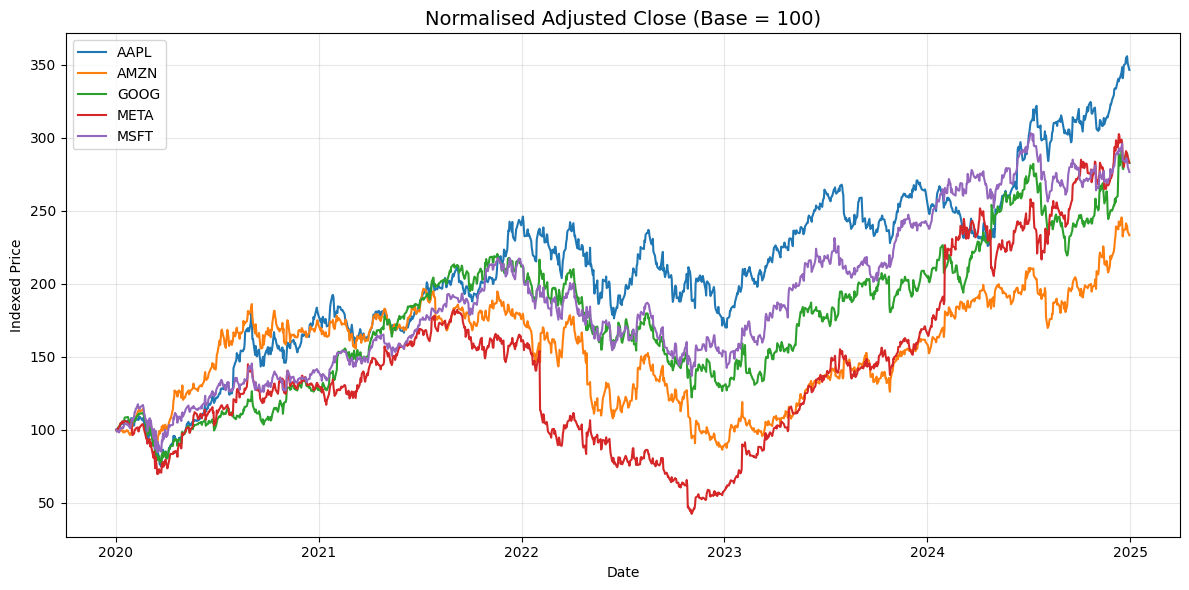

        Ann Return  Ann Vol  Sharpe
ticker                             
AAPL         0.300    0.317   0.945
AMZN         0.235    0.360   0.652
GOOG         0.261    0.324   0.806
META         0.311    0.449   0.692
MSFT         0.251    0.305   0.822


In [3]:
# Unstack to wide for plotting
close_wide = unstack_to_wide(prices, column="adj_close")

fig, ax = plt.subplots(figsize=(12, 6))
# Normalise to 100 at the start for comparability
normalised = close_wide / close_wide.iloc[0] * 100
for col in normalised.columns:
    ax.plot(normalised.index, normalised[col], linewidth=1.5, label=col)
ax.set_title("Normalised Adjusted Close (Base = 100)", fontsize=14)
ax.set_ylabel("Indexed Price")
ax.set_xlabel("Date")
ax.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

# Quick stats
daily_ret = simple_returns(prices["adj_close"]).dropna()
ann_ret = daily_ret.groupby(level="ticker").mean() * 252
ann_vol = daily_ret.groupby(level="ticker").std() * np.sqrt(252)
stats = pd.DataFrame({"Ann Return": ann_ret, "Ann Vol": ann_vol})
stats["Sharpe"] = stats["Ann Return"] / stats["Ann Vol"]
print(stats.round(3).to_string())

## 3. Implementing a Custom Provider

Suppose your firm has a REST API that serves historical prices.  Here we
build a `MockRestApiProvider` that generates realistic synthetic data
using NumPy, following the exact same `MarketDataProvider` contract.

The mock simulates geometric Brownian motion with per-ticker drift and
volatility, plus realistic OHLCV structure.

In [4]:
from qlab.data.base import MarketDataProvider

class MockRestApiProvider(MarketDataProvider):
    """Simulates a REST API returning daily OHLCV data.

    Generates deterministic synthetic prices using geometric Brownian
    motion so results are reproducible across runs.
    """

    def __init__(self, seed: int = 42):
        self.seed = seed

    def fetch(self, tickers, start, end):
        rng = np.random.default_rng(self.seed)
        start_ts = pd.Timestamp(start)
        end_ts = pd.Timestamp(end)
        dates = pd.bdate_range(start_ts, end_ts, name="date")
        n_days = len(dates)

        parts = []
        for ticker in tickers:
            # Per-ticker parameters derived from ticker name for variety
            ticker_hash = sum(ord(c) for c in ticker)
            annual_drift = 0.05 + (ticker_hash % 20) * 0.01   # 5-25% drift
            annual_vol = 0.15 + (ticker_hash % 15) * 0.01     # 15-30% vol
            initial_price = 50 + (ticker_hash % 200)           # $50-$250

            dt = 1 / 252
            daily_drift = (annual_drift - 0.5 * annual_vol ** 2) * dt
            daily_vol = annual_vol * np.sqrt(dt)

            # GBM simulation
            log_returns = rng.normal(daily_drift, daily_vol, n_days)
            log_prices = np.log(initial_price) + np.cumsum(log_returns)
            close_prices = np.exp(log_prices)

            # Realistic OHLCV structure
            intraday_range = rng.uniform(0.005, 0.025, n_days)
            high = close_prices * (1 + intraday_range * rng.uniform(0.3, 1.0, n_days))
            low = close_prices * (1 - intraday_range * rng.uniform(0.3, 1.0, n_days))
            open_prices = low + (high - low) * rng.uniform(0.2, 0.8, n_days)
            volume = rng.integers(500_000, 50_000_000, n_days).astype(float)

            df = pd.DataFrame({
                "open": open_prices,
                "high": high,
                "low": low,
                "close": close_prices,
                "volume": volume,
                "adj_close": close_prices,  # no splits in synthetic data
            }, index=dates)

            df["ticker"] = ticker
            df = df.reset_index().set_index(["date", "ticker"])
            parts.append(df)

        return pd.concat(parts).sort_index()


# --- Demonstrate the custom provider ---
mock = MockRestApiProvider(seed=42)
mock_tickers = ["SYNTH_A", "SYNTH_B", "SYNTH_C"]
mock_prices = mock.fetch(mock_tickers, "2022-01-01", "2024-06-30")

# Validate --- same function, no special handling needed
validate_prices(mock_prices)
print("MockRestApiProvider output passes validate_prices!")
print(f"Shape   : {mock_prices.shape}")
print(f"Tickers : {sorted(mock_prices.index.get_level_values('ticker').unique())}")
print(f"Columns : {list(mock_prices.columns)}")
print(f"\nSample data:")
mock_prices.head(6)

MockRestApiProvider output passes validate_prices!
Shape   : (1950, 6)
Tickers : ['SYNTH_A', 'SYNTH_B', 'SYNTH_C']
Columns : ['open', 'high', 'low', 'close', 'volume', 'adj_close']

Sample data:


open        high         low       close  \
date       ticker                                                    
2022-01-03 SYNTH_A  216.210680  219.402600  214.032961  217.146358   
           SYNTH_B  214.955563  218.468296  211.941293  215.922105   
           SYNTH_C  215.297765  217.649340  213.816064  215.781351   
2022-01-04 SYNTH_A  213.005636  214.346641  212.207428  213.543515   
           SYNTH_B  210.520235  213.252878  208.127958  210.246508   
           SYNTH_C  218.509781  219.647847  217.654963  218.800538   

                        volume   adj_close  
date       ticker                           
2022-01-03 SYNTH_A  21111565.0  217.146358  
           SYNTH_B  33791354.0  215.922105  
           SYNTH_C  46608090.0  215.781351  
2022-01-04 SYNTH_A  26901250.0  213.543515  
           SYNTH_B  28392200.0  210.246508  
           SYNTH_C  48674670.0  218.800538

In [5]:
# Show that qlab features work seamlessly on mock data
mock_returns = simple_returns(mock_prices["adj_close"]).dropna()
mock_ranked = rank(mock_returns)

print("Daily returns (head):")
print(mock_returns.head(6).to_string())
print(f"\nCross-sectional rank (head):")
print(mock_ranked.head(6).to_string())

Daily returns (head):
date        ticker 
2022-01-04  SYNTH_A   -0.016592
            SYNTH_B   -0.026285
            SYNTH_C    0.013992
2022-01-05  SYNTH_A    0.012673
            SYNTH_B   -0.015207
            SYNTH_C    0.001099

Cross-sectional rank (head):
date        ticker 
2022-01-04  SYNTH_A    0.666667
            SYNTH_B    0.333333
            SYNTH_C    1.000000
2022-01-05  SYNTH_A    1.000000
            SYNTH_B    0.333333
            SYNTH_C    0.666667


## 4. `ParquetCache` --- Transparent Disk Caching

`ParquetCache` wraps *any* `MarketDataProvider`.  On first call it
fetches from the upstream provider and saves a Parquet file; subsequent
calls read from disk.  This ensures:

* **Reproducibility** --- you always use the same data snapshot.
* **Speed** --- no network round-trip after the first fetch.
* **Interoperability** --- Parquet files can be read by R, Julia, Spark, etc.

In [6]:
import time, tempfile, shutil

# Use a temporary directory so we don't pollute the workspace
cache_dir = tempfile.mkdtemp(prefix="qlab_cache_demo_")
print(f"Cache directory: {cache_dir}")

mock = MockRestApiProvider(seed=99)
cached = ParquetCache(mock, cache_dir=cache_dir)

# --- First fetch: cache MISS (data generated + written to disk) ---
t0 = time.perf_counter()
data1 = cached.fetch(["ALPHA", "BETA"], "2023-01-01", "2023-12-31")
t_miss = time.perf_counter() - t0

# --- Second fetch: cache HIT (read from Parquet) ---
t0 = time.perf_counter()
data2 = cached.fetch(["ALPHA", "BETA"], "2023-01-01", "2023-12-31")
t_hit = time.perf_counter() - t0

print(f"Cache MISS (generate + write): {t_miss*1000:.1f} ms")
print(f"Cache HIT  (read parquet):     {t_hit*1000:.1f} ms")
print(f"Speed-up:                      {t_miss/max(t_hit, 1e-9):.1f}x")
print(f"\nData identical: {data1.equals(data2)}")

Cache directory: /tmp/qlab_cache_demo_9x4q7tsx
Cache MISS (generate + write): 11.5 ms
Cache HIT  (read parquet):     7.1 ms
Speed-up:                      1.6x

Data identical: True


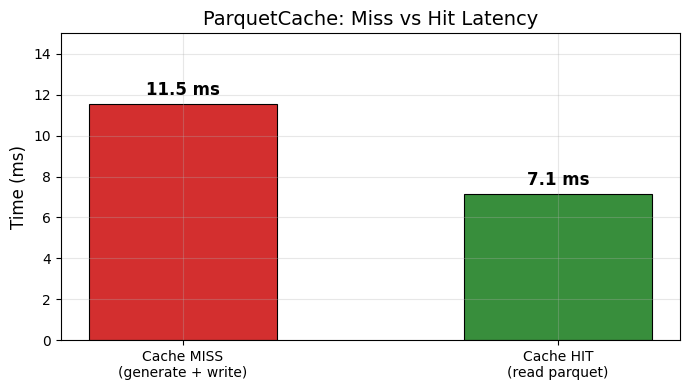

Cleaned up /tmp/qlab_cache_demo_9x4q7tsx


In [7]:
# --- Timing comparison bar chart ---
fig, ax = plt.subplots(figsize=(7, 4))
labels = ["Cache MISS\n(generate + write)", "Cache HIT\n(read parquet)"]
times_ms = [t_miss * 1000, t_hit * 1000]
colors = ["#d32f2f", "#388e3c"]
bars = ax.bar(labels, times_ms, color=colors, width=0.5, edgecolor="black", linewidth=0.8)

for bar, val in zip(bars, times_ms):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + max(times_ms) * 0.02,
            f"{val:.1f} ms", ha="center", va="bottom", fontsize=12, fontweight="bold")

ax.set_ylabel("Time (ms)", fontsize=12)
ax.set_title("ParquetCache: Miss vs Hit Latency", fontsize=14)
ax.set_ylim(0, max(times_ms) * 1.3)
plt.tight_layout()
plt.show()

# Clean up temporary cache
shutil.rmtree(cache_dir)
print(f"Cleaned up {cache_dir}")

## 5. Designing a `NewsProvider` Interface

Market data is just one type of input.  Let's design an alternative-data
interface for **news events** and show how to convert unstructured events
into a daily signal compatible with the qlab pipeline.

### Design

| Aspect | Price data | News data |
|--------|-----------|-----------|
| Frequency | Regular (one bar per trading day) | Irregular (zero or many events per day) |
| Schema | Numeric OHLCV | Mixed (text, categories, scores) |
| Coverage | Per-ticker, complete | Sparse (not every ticker every day) |

We define:
* `NewsEvent` --- a dataclass holding one event with sentiment.
* `NewsProvider` --- an ABC with a `fetch_news` method.
* `SyntheticNewsProvider` --- a concrete implementation generating mock events.
* `aggregate_news_to_daily` --- converts events to a daily `(date, ticker)` signal.

In [8]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List

@dataclass
class NewsEvent:
    """A single news event with sentiment."""
    timestamp: pd.Timestamp
    ticker: str
    headline: str
    sentiment: float      # in [-1, 1]
    source: str


class NewsProvider(ABC):
    """Abstract base class for news data providers."""

    @abstractmethod
    def fetch_news(
        self,
        tickers: list[str],
        start: str,
        end: str,
    ) -> List[NewsEvent]:
        """Fetch news events for the given tickers and date range.

        Returns
        -------
        list of NewsEvent
            Sorted by timestamp.
        """


class SyntheticNewsProvider(NewsProvider):
    """Generates deterministic mock news events for testing."""

    HEADLINES = [
        "{ticker} beats Q{q} earnings expectations",
        "{ticker} announces new product launch",
        "{ticker} faces regulatory scrutiny",
        "{ticker} CEO steps down unexpectedly",
        "{ticker} raises full-year guidance",
        "{ticker} reports supply chain disruptions",
        "{ticker} signs major partnership deal",
        "{ticker} stock downgraded by analysts",
        "{ticker} expands into new markets",
        "{ticker} announces share buyback program",
        "{ticker} revenue misses estimates",
        "{ticker} wins government contract",
    ]
    SOURCES = ["Reuters", "Bloomberg", "CNBC", "WSJ", "MarketWatch", "FT"]

    def __init__(self, avg_events_per_ticker_per_month: float = 4.0, seed: int = 42):
        self.avg_rate = avg_events_per_ticker_per_month
        self.seed = seed

    def fetch_news(self, tickers, start, end):
        rng = np.random.default_rng(self.seed)
        start_ts = pd.Timestamp(start)
        end_ts = pd.Timestamp(end)
        n_months = max(1, (end_ts - start_ts).days / 30)

        events = []
        for ticker in tickers:
            n_events = rng.poisson(self.avg_rate * n_months)
            # Random timestamps within the range
            offsets = rng.uniform(0, (end_ts - start_ts).total_seconds(), n_events)
            for offset in sorted(offsets):
                ts = start_ts + pd.Timedelta(seconds=float(offset))
                # Skip weekends
                if ts.weekday() >= 5:
                    continue
                headline_template = rng.choice(self.HEADLINES)
                headline = headline_template.format(
                    ticker=ticker, q=rng.integers(1, 5)
                )
                # Sentiment: slightly positive bias with heavy tails
                sentiment = float(np.clip(rng.normal(0.05, 0.4), -1, 1))
                source = str(rng.choice(self.SOURCES))
                events.append(NewsEvent(
                    timestamp=ts,
                    ticker=ticker,
                    headline=headline,
                    sentiment=sentiment,
                    source=source,
                ))

        events.sort(key=lambda e: e.timestamp)
        return events


# --- Demonstrate ---
news_provider = SyntheticNewsProvider(avg_events_per_ticker_per_month=5, seed=123)
news_tickers = ["AAPL", "MSFT", "GOOG"]
events = news_provider.fetch_news(news_tickers, "2024-01-01", "2024-06-30")

print(f"Total events generated: {len(events)}")
print(f"\nFirst 8 events:")
for e in events[:8]:
    print(f"  {e.timestamp.strftime('%Y-%m-%d %H:%M')}  {e.ticker:5s}  "
          f"sent={e.sentiment:+.2f}  [{e.source}]  {e.headline}")

Total events generated: 67

First 8 events:
  2024-01-03 16:42  AAPL   sent=+0.39  [CNBC]  AAPL signs major partnership deal
  2024-01-12 21:08  GOOG   sent=+0.23  [Bloomberg]  GOOG expands into new markets
  2024-01-15 10:42  GOOG   sent=+0.34  [MarketWatch]  GOOG announces new product launch
  2024-01-16 01:58  GOOG   sent=-0.10  [WSJ]  GOOG beats Q4 earnings expectations
  2024-01-25 19:04  GOOG   sent=-0.70  [MarketWatch]  GOOG beats Q2 earnings expectations
  2024-01-25 22:03  MSFT   sent=-0.06  [CNBC]  MSFT expands into new markets
  2024-01-30 02:39  MSFT   sent=+0.15  [WSJ]  MSFT faces regulatory scrutiny
  2024-01-31 00:41  AAPL   sent=-0.07  [Bloomberg]  AAPL revenue misses estimates


### Aggregating events to a daily signal

In [9]:
def aggregate_news_to_daily(events: List[NewsEvent]) -> pd.Series:
    """Convert a list of NewsEvent into a daily (date, ticker) sentiment signal.

    For each (date, ticker) pair, computes the mean sentiment across all
    events on that day.  Days with no events for a ticker are left as NaN
    (the caller can forward-fill or drop as needed).

    Parameters
    ----------
    events : list of NewsEvent
        Raw news events from any NewsProvider.

    Returns
    -------
    pd.Series
        MultiIndex (date, ticker), values are mean daily sentiment.
    """
    if not events:
        return pd.Series(dtype=float)

    records = [
        {"date": e.timestamp.normalize(), "ticker": e.ticker, "sentiment": e.sentiment}
        for e in events
    ]
    df = pd.DataFrame(records)
    daily = df.groupby(["date", "ticker"])["sentiment"].mean()
    daily.index = pd.MultiIndex.from_tuples(daily.index, names=["date", "ticker"])
    daily = daily.sort_index()
    return daily


# --- Aggregate and inspect ---
news_signal = aggregate_news_to_daily(events)
print(f"Daily signal shape: {news_signal.shape[0]} observations")
print(f"Date range: {news_signal.index.get_level_values('date').min().date()} to "
      f"{news_signal.index.get_level_values('date').max().date()}")
print(f"\nMean sentiment by ticker:")
print(news_signal.groupby(level="ticker").mean().round(3).to_string())
print(f"\nSample values:")
print(news_signal.head(10).to_string())

Daily signal shape: 62 observations
Date range: 2024-01-03 to 2024-06-28

Mean sentiment by ticker:
ticker
AAPL   -0.026
GOOG   -0.024
MSFT    0.088

Sample values:
date        ticker
2024-01-03  AAPL      0.393952
2024-01-12  GOOG      0.231151
2024-01-15  GOOG      0.341451
2024-01-16  GOOG     -0.099526
2024-01-25  GOOG     -0.702971
            MSFT     -0.064115
2024-01-30  MSFT      0.151853
2024-01-31  AAPL     -0.066609
2024-02-01  AAPL     -0.454640
2024-02-02  GOOG     -0.133225


### News event timeline

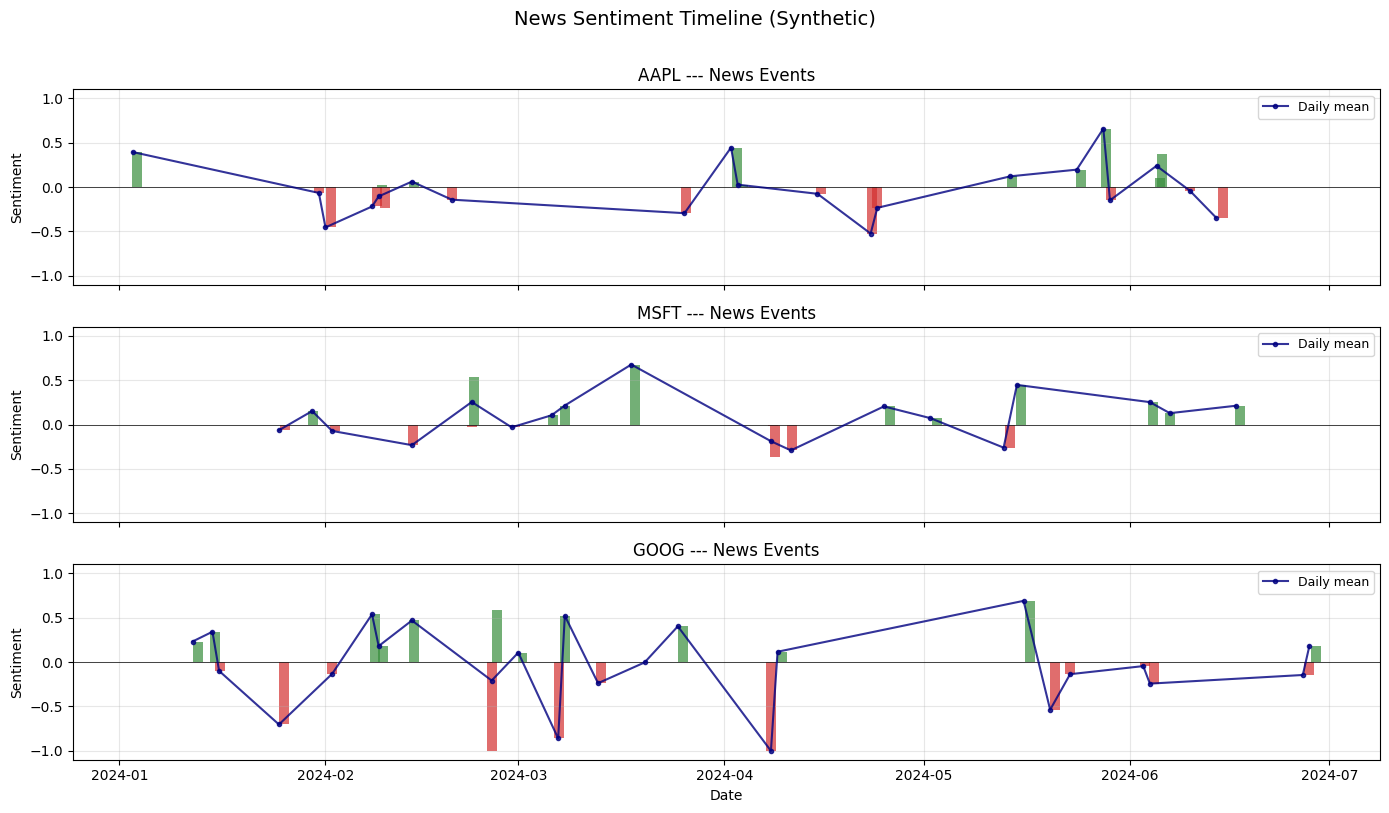

Events per (date, ticker) --- mean: 1.08, max: 2, min: 1


In [10]:
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

for ax, ticker in zip(axes, news_tickers):
    ticker_events = [e for e in events if e.ticker == ticker]
    dates = [e.timestamp for e in ticker_events]
    sentiments = [e.sentiment for e in ticker_events]

    colors = ["#388e3c" if s >= 0 else "#d32f2f" for s in sentiments]
    ax.bar(dates, sentiments, color=colors, width=1.5, alpha=0.7, edgecolor="none")
    ax.axhline(0, color="black", linewidth=0.5)
    ax.set_ylabel("Sentiment")
    ax.set_title(f"{ticker} --- News Events", fontsize=12)
    ax.set_ylim(-1.1, 1.1)

    # Overlay the daily aggregated signal
    if ticker in news_signal.index.get_level_values("ticker").unique():
        ts = news_signal.xs(ticker, level="ticker")
        ax.plot(ts.index, ts.values, color="navy", linewidth=1.5, alpha=0.8,
                label="Daily mean", marker="o", markersize=3)
        ax.legend(loc="upper right", fontsize=9)

axes[-1].set_xlabel("Date")
plt.suptitle("News Sentiment Timeline (Synthetic)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Event count distribution
event_df = pd.DataFrame([
    {"date": e.timestamp.normalize(), "ticker": e.ticker} for e in events
])
daily_counts = event_df.groupby(["date", "ticker"]).size()
print(f"Events per (date, ticker) --- mean: {daily_counts.mean():.2f}, "
      f"max: {daily_counts.max()}, min: {daily_counts.min()}")

## 6. Data Format Contracts

Every function in qlab expects data in specific formats.  Adhering to
these contracts ensures that you can swap data sources without touching
downstream code.

### Prices DataFrame

| Field | Type | Constraints |
|-------|------|-------------|
| **Index level 0**: `date` | `datetime64[ns]` | Sorted, business days, tz-naive |
| **Index level 1**: `ticker` | `str` | Non-empty, consistent casing |
| `open` | `float64` | > 0 |
| `high` | `float64` | >= `max(open, close)` |
| `low` | `float64` | <= `min(open, close)`, > 0 |
| `close` | `float64` | > 0 |
| `volume` | `float64` or `int64` | >= 0 |
| `adj_close` | `float64` | > 0; accounts for splits and dividends |

### Signal Series

| Field | Type | Constraints |
|-------|------|-------------|
| **Index level 0**: `date` | `datetime64[ns]` | Matches prices dates |
| **Index level 1**: `ticker` | `str` | Subset of universe |
| **Values** | `float64` | Finite or NaN (no +/-inf) |

### Weights Series

| Field | Type | Constraints |
|-------|------|-------------|
| **Index level 0**: `date` | `datetime64[ns]` | Matches prices dates |
| **Index level 1**: `ticker` | `str` | Subset of universe |
| **Values** | `float64` | Finite; per-date abs sum is finite |
| *Convention* | --- | Positive = long, negative = short |

In [11]:
# Demonstrate that validation catches bad data
from qlab.utils.validation import validate_prices, QlabValidationError

# --- Test 1: negative close price ---
bad_dates = pd.bdate_range("2024-01-01", periods=5)
bad_idx = pd.MultiIndex.from_product([bad_dates, ["BAD"]], names=["date", "ticker"])
bad_prices = pd.DataFrame({
    "open": [100.0, 101, 102, 103, 104],
    "high": [105.0, 106, 107, 108, 109],
    "low":  [95.0, 96, 97, 98, 99],
    "close": [100.0, 101, -1, 103, 104],   # negative close!
    "volume": [1e6] * 5,
    "adj_close": [100.0, 101, -1, 103, 104],
}, index=bad_idx)

try:
    validate_prices(bad_prices)
except QlabValidationError as e:
    print(f"Test 1 - Caught: {e}")

# --- Test 2: missing required column ---
bad_prices2 = bad_prices.drop(columns=["volume"])
try:
    validate_prices(bad_prices2)
except QlabValidationError as e:
    print(f"Test 2 - Caught: {e}")

# --- Test 3: wrong index type ---
bad_prices3 = bad_prices.reset_index(drop=True)
try:
    validate_prices(bad_prices3)
except QlabValidationError as e:
    print(f"Test 3 - Caught: {e}")

print("\nAll validation guards work correctly.")

Test 1 - Caught: prices['close'] contains 1 non-positive value(s).
Test 2 - Caught: prices DataFrame missing required columns: ['volume'].
Test 3 - Caught: prices must have a 2-level MultiIndex (date, ticker); got RangeIndex with 1 level(s).

All validation guards work correctly.


## 7. Reproducibility Checklist and Recommended Project Layout

### Reproducibility checklist

| Step | How qlab helps |
|------|---------------|
| Pin data snapshot | `ParquetCache` writes immutable Parquet files |
| Version data files | Commit cache directory or use DVC |
| Record provider settings | `inspect.signature` + `__init__` args |
| Seed random state | `MockRestApiProvider(seed=42)` |
| Lock dependencies | `pip freeze > requirements.txt` |
| Log run metadata | `BacktestConfig` is a frozen dataclass |
| Timezone consistency | All dates are tz-naive `datetime64[ns]` normalised to midnight |

### Recommended project layout

```
my_research/
+-- data/
|   +-- raw/                  # ParquetCache output (git-ignored)
|   +-- processed/            # Feature matrices
|   +-- data_manifest.json    # Records what was fetched and when
+-- notebooks/
|   +-- 01_exploration.ipynb
|   +-- 02_backtest.ipynb
+-- src/
|   +-- providers/
|   |   +-- my_api.py         # Custom MarketDataProvider subclass
|   |   +-- news.py           # Custom NewsProvider subclass
|   +-- signals/
|   |   +-- momentum.py
|   |   +-- news_signal.py
|   +-- config.py             # Tickers, dates, parameters
+-- tests/
|   +-- test_providers.py
|   +-- test_signals.py
+-- pyproject.toml
+-- README.md
```

In [12]:
# Show how to introspect provider configuration for logging
import inspect

provider_info = {
    "class": type(provider).__name__,
    "module": type(provider).__module__,
    "init_signature": str(inspect.signature(type(provider).__init__)),
}
print("Provider metadata for reproducibility logging:")
for k, v in provider_info.items():
    print(f"  {k}: {v}")

# Demonstrate determinism of MockRestApiProvider
mock_a = MockRestApiProvider(seed=42).fetch(["X", "Y"], "2023-01-01", "2023-06-30")
mock_b = MockRestApiProvider(seed=42).fetch(["X", "Y"], "2023-01-01", "2023-06-30")
print(f"\nDeterminism check: same seed produces identical data = {mock_a.equals(mock_b)}")

mock_c = MockRestApiProvider(seed=99).fetch(["X", "Y"], "2023-01-01", "2023-06-30")
print(f"Different seed produces different data = {not mock_a.equals(mock_c)}")

Provider metadata for reproducibility logging:
  class: YFinanceProvider
  module: qlab.data.yfinance_provider
  init_signature: (self, auto_adjust: 'bool' = True, progress: 'bool' = False) -> 'None'

Determinism check: same seed produces identical data = True
Different seed produces different data = True


## 8. Summary

| Topic | Key takeaway |
|-------|-------------|
| `MarketDataProvider` | Single abstract method `fetch()` --- implement once, use everywhere |
| `YFinanceProvider` | Production-ready provider for US equities via yfinance |
| Custom providers | Subclass `MarketDataProvider`, return stacked `(date, ticker)` DataFrame |
| `ParquetCache` | Wrap any provider for reproducibility and speed |
| Alternative data | Define your own ABCs (e.g. `NewsProvider`); aggregate to daily `(date, ticker)` signals |
| Data contracts | Prices: 6 OHLCV+adj columns; Signals: float Series; Weights: finite float Series |
| Reproducibility | Pin data, seed RNG, log configs, version everything |

### Next steps

* **Tutorial 6** --- Build a multi-factor model combining price and alternative-data signals.
* Try connecting a real API (Alpha Vantage, Polygon.io, Databento) by
  subclassing `MarketDataProvider`.
* Experiment with different cache backends (SQLite, HDF5) by following
  the `ParquetCache` pattern.